In [1]:
import pygame, sys, random
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

In [2]:
input_size = 22
output_size = 8
hidden_size = 10
learning_rate = 0.1

X = tf.placeholder(tf.float32,  [None, input_size], name = "input_x")
W1 = tf.get_variable("W1", shape = [input_size, hidden_size], initializer = tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.tanh(tf.matmul(X, W1))
W2 = tf.get_variable("W2", shape = [hidden_size, output_size], initializer = tf.contrib.layers.xavier_initializer())

Qpred = tf.matmul(layer1, W2)

Y = tf.placeholder(shape  = [None, output_size], dtype = tf.float32)

loss = tf.reduce_sum(tf.square(Y-Qpred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

In [3]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < 400):
        xPos = 400
        flagWall = -1
    elif(xPos > 880):
        xPos = 880
        flagWall = -1
    if(yPos > 690):
        yPos = 690
        flagWall = -1
    elif(yPos < 210):
        yPos = 210
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [4]:
def stateGenerator(obsPosition, agtPosition, wallcheck):
    returnSum = []
    for i in range(0,10):
        #returnSum = returnSum + [math.sqrt((agtPosition[0] - obsPosition[i][0])**2 + (agtPosition[1] - obsPosition[i][1])**2)]
        returnSum = returnSum + [agtPosition[0] - obsPosition[i][0], agtPosition[1] - obsPosition[i][1]]
    returnSum = returnSum + [agtPosition[0] - 640, agtPosition[1] - 450]
    return returnSum

In [ ]:
#display
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

num_episodes = 10000
dis = 0.9
rList = []

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for episodes in range(num_episodes):
        
        x = 400
        y = 690
        obstaclePos = [[0, 0] for _ in range(10)]
        for i in range(0,10):
            while True:
                obstaclePos[i][0] = 400 + random.randrange(1,490)
                obstaclePos[i][1] = 690 - random.randrange(1,490)
                if obstaclePos[i][0] <= 620 or obstaclePos[i][0] >= 660:
                    if obstaclePos[i][1] >= 470 or obstaclePos[i][1] <= 430:
                        break

        s = stateGenerator(obstaclePos, [x,y], -1)
        #e = 1. / ((episodes/10) + 1)
        e = 0.1
        rAll = 0
        step_count = 0
        ObjectIndex = -1
        while True:
            step_count += 1
            Qinput = np.reshape(s, [1, input_size])
            Qs = sess.run(Qpred, feed_dict = {X: Qinput})
            
            if np.random.rand(1) < e:
                a = random.randrange(0,8)
            else:
                a = np.argmax(Qs)
            
            xMove = 0
            yMove = 0
            if a == 0:
                xMove = 1
            elif a == 1:
                xMove = 1
                yMove = 1
            elif a == 2:
                yMove = 1
            elif a == 3:
                xMove = -1
                yMove = 1
            elif a == 4:
                xMove = -1
            elif a == 5:
                xMove = -1
                yMove = -1
            elif a == 6:
                yMove = -1
            elif a == 7:
                xMove = 1
                yMove = -1

            x = x + xMove
            y = y + yMove
            
            wallFlag = 0
            collisionFlag = 0
            [x, y, wallFlag] = ckWall(x, y)
            pygame.draw.circle(screen, [100,100,255],[x,y],10,0)

            ## Draw Environment (Obstacle + Map)
            for i in range(0,10):
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                if obstaclePos[i][0] == 621:
                    obstaclePos[i][0] = 620
                elif obstaclePos[i][0] == 639:
                    obstaclePos[i][0] = 640
                    
                if obstaclePos[i][1] == 431:
                    obstaclePos[i][1] = 430
                elif obstaclePos[i][1] == 469:
                    obstaclePos[i][1] = 470
                
                pygame.draw.circle(screen, [255, 50, 50], obstaclePos[i], 10, 0)
                if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                    print("Collision!")
                    collisionFlag = -1
                    ObjectIndex = i
            s1 = stateGenerator(obstaclePos, [x,y], wallFlag)
            
            # more close to the goal, more reward agent can get
            distToGoal = math.sqrt((x - 640)**2 + (y - 450)**2)
            if distToGoal == 0 or 1/distToGoal >= 100000:
                reward = 100000
            else:
                reward = 100000/distToGoal

            if(math.sqrt((x - 640)**2 + (y - 450)**2) <= 20):
                print("Goal Reached!")
                collisionFlag = 1
            
            if collisionFlag == -1 or wallFlag == -1:
                Qs[0, a] = -10000
                rList.append(0)
            elif collisionFlag == 1:
                Qs[0, a] = 100000
                rList.append(1)
            else:
                Qinput1 = np.reshape(s1, [1, input_size])
                Qs1 = sess.run(Qpred, feed_dict = {X: Qinput1})
                Qs[0,a] = reward + dis * np.max(Qs1)
            
            sess.run(train, feed_dict={X: Qinput, Y: Qs})
            s = s1
            
            if episodes % 100 == 0:
                print(Qs)
                print reward
            
            if collisionFlag == 1 or collisionFlag == -1:
                break
            pygame.draw.circle(screen, [100,255,100], [640, 450], 20, 1)
            pygame.draw.rect(screen, [255,100,100],[390,200,500,500],1)
            pygame.display.flip()
            screen.fill([200,200,200])
        print("Episode : {}, Object Index: {}".format(episodes, ObjectIndex))

[[  8.08961511e-01  -1.00000000e+04  -3.30742776e-01   1.01927328e+00
   -1.32234025e+00   3.44277859e-01   1.46354139e-02  -1.06841016e+00]]
295.242271506
[[  8.08961511e-01   3.68094921e-01  -3.30742776e-01  -1.00000000e+04
   -1.32234025e+00   3.44277859e-01   1.46354139e-02  -1.06841016e+00]]
294.627825494
[[  2.95970337e+02  -3.01961124e-01  -3.30742776e-01   2.75138915e-01
   -1.32234025e+00   3.44277859e-01   1.46354139e-02  -1.06841016e+00]]
295.242271506
[[  2.97160980e+02  -8.19914579e-01  -3.30742776e-01  -3.00077021e-01
   -1.32234025e+00   3.44277859e-01   1.46354139e-02  -1.06841016e+00]]
295.857988166
[[  2.98480835e+02  -1.24419212e+00  -3.30742776e-01  -7.71260619e-01
   -1.32234025e+00   3.44277859e-01   1.46354139e-02  -1.06841016e+00]]
296.474967152
[[  2.99867676e+02  -1.60280371e+00  -3.30742776e-01  -1.16951859e+00
   -1.32234025e+00   3.44277859e-01   1.46354139e-02  -1.06841016e+00]]
297.093199921
[[  3.98142934e+00  -1.91188002e+00  -3.30742776e-01  -1.5127650

[[  4.29342102e+02  -8.79794598e+00  -3.30742776e-01  -9.91525173e+00
    4.04131937e+00   5.45613527e+00   1.46354139e-02  -1.06841016e+00]]
348.02034837
[[  4.30990936e+02  -8.79865170e+00  -3.30742776e-01  -9.93240547e+00
    4.04161167e+00   5.45626163e+00   1.46354139e-02  -1.06841016e+00]]
348.686141556
[[  4.32639893e+02  -8.79929066e+00  -3.30742776e-01  -9.94793129e+00
    4.04187632e+00   5.45637608e+00   1.46354139e-02  -1.06841016e+00]]
349.351506792
[[  4.34288940e+02  -8.79986858e+00  -3.30742776e-01  -9.96198368e+00
    4.04211569e+00   5.45647860e+00   1.46354139e-02  -1.06841016e+00]]
350.016407404
[[  4.35938019e+02  -8.80039215e+00  -3.30742776e-01  -9.97470093e+00
    4.04233170e+00   5.45657301e+00   1.46354139e-02  -1.06841016e+00]]
350.680806277
[[  4.37587067e+02  -8.80086613e+00  -3.30742776e-01  -9.98620987e+00
    4.04252815e+00   5.45665789e+00   1.46354139e-02  -1.06841016e+00]]
351.344665857
[[  4.39236053e+02  -8.80129337e+00  -3.30742776e-01  -9.99662399

[[ 560.71362305   -8.8053484   -17.43644905  -16.43815231   14.11573315
    15.37704563   17.96017647   -1.06841016]]
397.762908107
[[ 562.22033691   -8.8053484   -17.42522621  -16.43876266   14.13864708
    15.47861862   17.98352432   -1.06841016]]
398.270482139
[[ 563.72662354   -8.8053484   -17.41509819  -16.4393158    14.15933228
    15.57031155   18.00460052   -1.06841016]]
398.773662779
[[ 565.2321167    -8.8053484   -17.40595436  -16.43981171   14.17800522
    15.65308094   18.02362823   -1.06841016]]
399.272390137
[[ 566.73632812   -8.8053484   -17.39770126  -16.44026184   14.1948595
    15.72780132   18.040802     -1.06841016]]
399.766604435
[[ 568.23883057   -8.8053484   -17.39024925  -16.4406662    14.21007633
    15.79524803   18.05630684   -1.06841016]]
400.256246022
[[ 569.73937988   -8.8053484   -17.38352394  -16.44103241   14.22381115
    15.8561306    18.07030106   -1.06841016]]
400.741255394
[[ 571.23754883   -8.8053484   -17.37745476  -16.44136238   14.23620892
    1

[[ 669.70043945  -16.71132088  -16.7197628   -15.41511536   37.03871918
    27.41547394   41.70923996    9.45813942]]
421.757004859
[[ 670.40447998  -16.65049171  -16.71974564  -15.41506386   38.15016556
    28.34952545   41.7301445     9.94674397]]
421.805777425
[[ 671.14044189  -16.59562874  -16.71972656  -15.41501617   39.15255356
    29.19192505   41.74898911   10.38740349]]
421.847059737
[[ 671.90429688  -16.54615211  -16.71971321  -15.41497326   40.05657578
    29.95166016   41.76599121   10.78482342]]
421.880845191
[[ 672.69244385  -16.50152969  -16.71969986  -15.41493511   40.87188339
    30.63684082   41.78131866   11.14324188]]
421.90712838
[[ 673.50152588  -16.46128654  -16.71968842  -15.41490078   41.60717392
    31.254776     41.79514694   11.46648407]]
421.925905094
[[ 674.32855225  -16.42499352  -16.71967697  -15.41486931   42.270298
    31.81206131   41.807621     11.75800228]]
421.937172326
[[ 281.3666687   -16.39226151  -16.71966934  -15.4148407    42.86833954
    32.

Percent of successful episodes: 0%


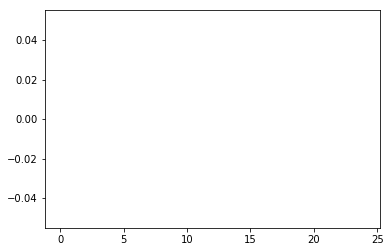

In [7]:
print("Percent of successful episodes: " + str(sum(rList)/num_episodes) + "%")
plt.bar(range(len(rList)), rList, color = "white", width = 0.00001)
plt.show()